# 导包

In [45]:
import torch
import torchvision
import torch.nn
import torch.nn.init
import torch.utils.data as data
# print(torch.__version__)
# print(torchvision.__version__)
# print(torch.cuda.is_available())
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [32]:
import data

In [2]:
def try_gpu():
    """If GPU is available, return torch.device as cuda:0; else return torch.device as cpu."""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = try_gpu()
device

device(type='cuda', index=0)

# 卷积神经网络基础

## Cov2D
`torch.nn.Conv2D的输入形状是（batch_size, input_channels, height, weight）`

###  二维互相关运算
- Conv2D实际执行的是二维互相关运算。
- 二维互相关运算的核数组左右、上下翻转才是二维卷积运算。

In [3]:
def corr2d(X, K):
    """
    对二维特折X与核K进行卷积运算。
    
    :param X:二维输入特征（H,W） 
    :param K: 核数组（h,w）
    :return: 二维输出。
    """
    h, w = K.shape
    Y = torch.zeros(X.shape[0]-h+1, X.shape[1]-w+1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h,j:j+w] * K).sum()
    return Y

In [4]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 无通道卷积层

In [5]:
class Conv2D(torch.nn.Module):
    """
    构造二维卷积层
    """
    def __init__(self, kernel_size):
        """
        构造二维卷积层
        :param kernel_size: 核大小(h,w)。
        """
        super(Conv2D, self).__init__()
        self.weight = torch.nn.Parameter(torch.randn(kernel_size))
        self.bias = torch.nn.Parameter(torch.randn(1))
        
    def forward(self, X):
        """
        前向运算，
        :param X: 二维输入特征（H,W）。
        :return: 二维输出。 
        """
        return corr2d(X, self.weight) + self.bias

### 卷积层学习

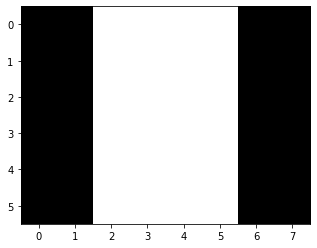

In [6]:
X = torch.ones(6, 8)
X[:, 2:6] = 0
plt.imshow(X.numpy(), cmap="gray_r")

In [7]:
K = torch.tensor([[1, -1]])
# 检测边缘算子

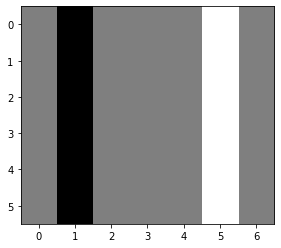

In [8]:
Y = corr2d(X, K)
plt.imshow(Y.numpy(), cmap="gray_r")

In [9]:
conv2d = Conv2D(kernel_size=(1, 2))
step, lr = 20, 0.01

for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y_hat - Y) ** 2).sum()
    l.backward()

    conv2d.weight.data -= lr * conv2d.weight.grad
    conv2d.bias.data -= lr * conv2d.bias.grad

    conv2d.weight.grad.fill_(0)
    conv2d.bias.grad.fill_(0)
    if (i + 1) % 5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))

Step 5, loss 23.787
Step 10, loss 5.112
Step 15, loss 1.255
Step 20, loss 0.331


In [10]:
print("weight: ", conv2d.weight.data, K)
print("bias: ", conv2d.bias.data)

weight:  tensor([[ 0.8408, -0.8726]]) tensor([[ 1, -1]])
bias:  tensor([0.0178])


## 特征图与感受野
- 特征图：二维卷积层的输出，也是一个二维数组；
- 感受野：影响元素x的前向计算的所有可能输入区域，堆叠Conv2D可以增大感受野。

## 填充padding与步幅stride
$${(H_Y, W_Y)} = \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

### 填充
- 填充上下左右可以用不同的填充，但一般填充的数量一样。
- 卷积神经网络经常使用奇数高宽的卷积核，如1、3、5和7，所以两端上的填充个数相等，填充数量为$\frac{k-1}{2}$。

In [11]:
conv2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
X = torch.rand(8, 8)
X = X.view((1, 1) + X.shape)
conv2d(X).shape[2:]

torch.Size([8, 8])

In [12]:
conv2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 3), padding=(2, 1))
conv2d(X).shape[2:]

torch.Size([8, 8])

### 步幅
卷积窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动，每次滑动的行数和列数称为步幅（stride）。

In [13]:
conv2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=2)
conv2d(X).shape[2:]

torch.Size([4, 4])

In [14]:
conv2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 5), padding=(0, 1), stride=(3,4))
conv2d(X).shape[2:]

torch.Size([2, 2])

## 多输入通道和多输出通道
### 多输入通道
- 当 ci=1 时，卷积核只包含一个形状为 $k_h×k_w$ 的二维数组；
- 当 ci>1 时，每个输入通道均包含一个形状为 $k_h×k_w$ 的核数组，把这 ci 个数组在输入通道维上连结，即得到一个形状为 ci×kh×kw 的卷积核；
- 多输入通道的输出是 ci 个互相关运算的二维输出按通道相加；

In [15]:
def corr2d_multi_in(X, K):
    """
    多输入通道的二维互相关运算。
    :param X: 三维输入特征（in_channels, Height, Width）
    :param K: 三维卷积数组(in_channels, height, width)
    :return: 二维输出，与输入通道数无关。
    """
    Y = corr2d(X[0,:,:], K[0,:,:])
    for i in range(1,X.shape[0]):
        Y += corr2d(X[i,:,:], K[i,:,:])
    return Y

In [16]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])
X.shape, K.shape

(torch.Size([2, 3, 3]), torch.Size([2, 2, 2]))

In [17]:
corr2d(X[0,:,:], K[0,:,:]).shape

torch.Size([2, 2])

In [18]:
corr2d_multi_in(X, K).shape

torch.Size([2, 2])

### 多输出通道
相当于设计了多个特征，在输出通道上连接结果，卷积核形状为$c_out×c_in×k_h×k_w$。

In [19]:
def corr2d_multi_in_out(X, K):
    """
    多输入&输出通道的二维互相关运算。
    
    :param X: 三维输入特征（in_channels, Height, Width）
    :param K: 四维卷积数组(out_channels, in_channels, height, width)
    :return: 三维输出，与输入通道数无关(out_channels, height, width)。
    """
    return torch.stack([corr2d_multi_in(X,k) for k in K],dim=0)

In [20]:
K = torch.stack([K, K + 1, K + 2])

In [21]:
corr2d_multi_in_out(X, K).shape

torch.Size([3, 2, 2])

## 1x1卷积层
如果将通道维当作特征维，1x1卷积层与全连接层的作用等级，保持高度与宽度不变。

In [22]:
def corr2d_multi_in_out_1x1(X, K):
    """
    1x1卷积层等效于通道维的全连接层。

    :param X: 三维输入特征（in_channels, Height, Width）
    :param K: 四维卷积数组(out_channels, in_channels, 1, 1)
    :return: 三维输入特征（out_channels, Height, Width）
    """
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.view(c_i, h * w)
    K = K.view(c_o, c_i)
    Y = torch.mm(K, X)  # 全连接层的矩阵乘法
    return Y.view(c_o, h, w)

In [23]:
X = torch.rand(3, 3, 3)
K = torch.rand(2, 3, 1, 1)

In [24]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y1.shape

torch.Size([2, 3, 3])

In [25]:
Y2 = corr2d_multi_in_out(X, K)
Y2.shape

torch.Size([2, 3, 3])

## 卷积层的优势
- 保存空间信息：全连接层把图像展平成一个向量，在输入图像上相邻的元素可能因为展平操作不再相邻，网络难以捕捉局部信息。而卷积层的设计，天然地具有提取局部信息的能力。

- 卷积层的参数量更少：不考虑偏置的情况下，一个形状为$(c_i, c_o, h, w)$的卷积核的参数量是$c_i \times c_o \times h \times w$，与输入图像的宽高无关。假如一个卷积层的输入和输出形状分别是$(c_1, h_1, w_1)$和$(c_2, h_2, w_2)$，如果要用全连接层进行连接，参数数量就是$c_1 \times c_2 \times h_1 \times w_1 \times h_2 \times w_2$。使用卷积层可以以较少的参数数量来处理更大的图像。

## 池化层
池化层的作用是缓解卷积层对位置的过度敏感性，池化层直接计算池化窗口内元素的最大值或者平均值。

- 池化层的填充、步幅与卷积层性质相同；
- 池化层对每个通道分别池化，而不是像卷积层那样将各通道的输入按通道相加，池化层的$Channels_{in} = Channels_{out}$。
- 池化层没有模型参数，但要参与反向传播。

- `torch.nn.MaxPool2d`
- `torch.nn.AvgPool2d`

In [26]:
def pool2d(X, pool_size, mode='max'):
    """
    对二维特征X进行池化操作。
    :param X: 二维输入特征（H,W）
    :param pool_size: 池化窗口大小(p,q)。
    :param mode: 二维输出。
    :return: 
    """
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [27]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
X.shape

torch.Size([3, 3])

In [28]:
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [29]:
X = torch.arange(16, dtype=torch.float).view((1, 1, 4, 4))
X = torch.cat((X, X + 1), dim=1)
X.shape

torch.Size([1, 2, 4, 4])

In [30]:
maxpool2d = torch.nn.MaxPool2d(3, padding=1, stride=2)
maxpool2d(X).shape

torch.Size([1, 2, 2, 2])

# LeNet
- 卷积层保留输入形状，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；
- 卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。

![LeNet网络结构](https://tangshusen.me/Dive-into-DL-PyTorch/img/chapter05/5.5_lenet.png)

## 组成
LeNet分为卷积层块和全连接层块两个部分：
- 卷积层块里的基本单位是卷积层后接最大池化层，卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性，卷积层块由两个这样的基本单位重复堆叠构成。
    - 卷积层使用5×5窗口，激活函数使用sigmoid，第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。
    - 池化层使用2×2窗口的最大池化，步幅为2，池化窗口在输入上每次滑动所覆盖的区域互不重叠。
    - 卷积层块的输出形状为(批量大小, 通道, 高, 宽)。
- 全连接层块含3个全连接层，它们的输出个数分别是120、84和10，其中10为输出的类别个数。
    - 当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本变平（flatten）。
- LeNet
    - 输入是图像:`(batch_size, 1, 28, 28)`
    - 输出是类别：`(batch_size, 10)`

## 数据集

In [34]:
batch_size, num_workers = 256, 4
train_iter = torch.utils.data.DataLoader(data.mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(data.mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

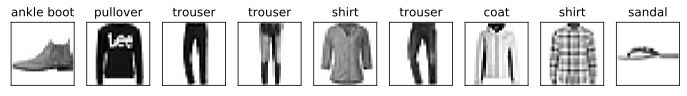

In [37]:
X, y = iter(test_iter).next()
true_labels = data.get_fashion_mnist_labels(y.numpy())
titles = [lb for lb in true_labels]
data.show_fashion_mnist(X[0:9], titles[0:9])

In [38]:
len(train_iter), len(test_iter)

(235, 40)

In [39]:
X.shape, y.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

## 定义网络

In [40]:
class Flatten(torch.nn.Module): 
    """
    把高维特征展平成一维特征。
    """
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [41]:
class Reshape(torch.nn.Module): 
    """
    规范LeNet的输入特征为1x28x28。
    """
    def forward(self, x):
        return x.view(-1,1,28,28)

In [42]:
net = torch.nn.Sequential(                                                 
    Reshape(),
    torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    #b*1*28*28  =>b*6*28*28
    torch.nn.Sigmoid(),       
    torch.nn.AvgPool2d(kernel_size=2, stride=2),     
    #b*6*28*28  =>b*6*14*14
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),      
    #b*6*14*14  =>b*16*10*10
    torch.nn.Sigmoid(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),                              
    #b*16*10*10  => b*16*5*5
    Flatten(),                                                          
    torch.nn.Linear(in_features=16*5*5, out_features=120),
    #b*16*5*5   => b*400
    torch.nn.Sigmoid(),
    torch.nn.Linear(120, 84),
    torch.nn.Sigmoid(),
    torch.nn.Linear(84, 10)
)

In [43]:
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [44]:
def evaluate_accuracy(data_iter, net,device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    acc_sum,n = torch.tensor([0],dtype=torch.float32,device=device),0
    for X,y in data_iter:
        # If device is the GPU, copy the data to the GPU.
        X,y = X.to(device),y.to(device)
        net.eval()
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))  #[[0.2 ,0.4 ,0.5 ,0.6 ,0.8] ,[ 0.1,0.2 ,0.4 ,0.3 ,0.1]] => [ 4 , 2 ]
            n += y.shape[0]
    return acc_sum.item()/n

In [52]:
def train_ch5(net, train_iter, test_iter,criterion, num_epochs, batch_size, device,lr=None):
    """和basic.py中的定义不同。"""
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_l_sum = torch.tensor([0.0],dtype=torch.float32,device=device)
        train_acc_sum = torch.tensor([0.0],dtype=torch.float32,device=device)
        n, start = 0, time.time()
        for X, y in train_iter:
            net.train()
            
            optimizer.zero_grad()
            X,y = X.to(device),y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net,device)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc,
                 time.time() - start))

In [53]:
lr, num_epochs = 0.9, 10

def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
net = net.to(device)

criterion = torch.nn.CrossEntropyLoss()   #交叉熵描述了两个概率分布之间的距离，交叉熵越小说明两者之间越接近
train_ch5(net, train_iter, test_iter, criterion,num_epochs, batch_size,device, lr)

training on cuda:0
epoch 1, loss 0.0091, train acc 0.103, test acc 0.100, time 5.4 sec
epoch 2, loss 0.0077, train acc 0.236, test acc 0.525, time 3.4 sec
epoch 3, loss 0.0038, train acc 0.613, test acc 0.630, time 3.4 sec
epoch 4, loss 0.0030, train acc 0.702, test acc 0.616, time 3.4 sec
epoch 5, loss 0.0026, train acc 0.741, test acc 0.701, time 3.5 sec
epoch 6, loss 0.0023, train acc 0.767, test acc 0.776, time 3.3 sec
epoch 7, loss 0.0021, train acc 0.790, test acc 0.797, time 3.3 sec
epoch 8, loss 0.0020, train acc 0.805, test acc 0.744, time 3.4 sec
epoch 9, loss 0.0019, train acc 0.816, test acc 0.808, time 3.3 sec
epoch 10, loss 0.0018, train acc 0.827, test acc 0.807, time 3.4 sec


In [54]:
for testdata,testlabe in test_iter:
    testdata,testlabe = testdata.to(device),testlabe.to(device)
    break
print(testdata.shape,testlabe.shape)
net.eval()
y_pre = net(testdata)
print(torch.argmax(y_pre,dim=1)[:10])
print(testlabe[:10])

torch.Size([256, 1, 28, 28]) torch.Size([256])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], device='cuda:0')
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], device='cuda:0')


# AlexNet：深度卷积神经网络
- `torchvision.models.AlexNetDroupout
- `torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`
- `torch.nn.MaxPool2d(kernel_size, stride=None, padding=0)`
- `torch.nn.Linear`
- `torch.nn.ReLU`
- `torch.nn.Droupout`

AlexNet的特征不是设计的，是自动学习的，首次证明了学习到的特征可以超越手工设计的特征。

## 制约深度学习发展的两大难题：
- 数据集：
    1. 包含许多特征的深度模型需要大量的有标签的数据才能表现得比其他经典方法更好，限于早期计算机有限的存储和90年代有限的研究预算，大部分研究只基于小的公开数据集。
    2. 2009年诞生的ImageNet数据集（李飞飞）包含了1,000大类物体，每类有多达数千张不同的图像。
- 硬件：
    1. 深度学习对计算资源要求很高，通用GPU的到来解决了这一问题。很久以来，GPU都是为图像处理和计算机游戏设计的，尤其是针对大吞吐量的矩阵和向量乘法从而服务于基本的图形变换。
    2. 用GPU这个概念在2001年开始兴起，涌现出诸如OpenCL和CUDA之类的编程框架。这使得GPU也在2010年前后开始被机器学习社区使用。

## 结构
AlexNet包含8层变换：
- 5个卷积层
    1. `11×11Cov2d`+`3×3MaxPool2D`
    2. `5×5Cov2d`+`3×MaxPool2D`
    3. `3×3`
    4. `3×3`
    5. `3×3Cov2d`+`3×MaxPool2D`
- 2个全连接隐藏层
- 1个全连接输出层

![AlexNet的结构](https://tangshusen.me/Dive-into-DL-PyTorch/img/chapter05/5.6_alexnet.png)
$$\text{图1 AlexNet的结构}$$

## 改进
1. 激活函数是`ReLU`；
2. 引入了`Dropout`；
3. 引入了大量的图像增广，如翻转、裁剪和颜色变化，从而进一步扩大数据集来缓解过拟合。

In [2]:
class AlexNet(torch.nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 96, 11, 4), 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2), 
            torch.nn.Conv2d(96, 256, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2),
            torch.nn.Conv2d(256, 384, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(384, 384, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(384, 256, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256*5*5, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            torch.nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

# PyTorch的模型API
- `Pytorch`和`MXNet`相比，通过API创建模型不需要初始化，但是需要显示指定模型的shape。
- `MXNet`的模型参数可以延后初始化，模型参数尺寸根据输入尺寸调整，更加灵活。

# VGG：使用重复元素的网络
由多个`VGG_BLOCK`组成，每个`VGG_BLOCK`连续使用数个相同的填充为1、窗口形状为 3×3 的卷积层后接上一个步幅为2、窗口形状为 2×2 的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。

**AlexNet比LeNet学习能力更强，但是AlexNet没有解决深度学习模型设计的问题。**

![VGG的结构](https://staticcdn.boyuai.com/materials/2020/02/15/by2wiwCbEl8N4NbZGQh-9.png!png)

# NiN：网络中的网络
- LeNet、AlexNet和VGG：先以由卷积层构成的模块充分抽取 空间特征，再以由全连接层构成的模块来输出分类结果。

- NiN：串联多个由卷积层和“全连接”层构成的小⽹络来构建⼀个深层⽹络。NiN去掉了AlexNet最后的3个全连接层，取而代之地，NiN使用了输出通道数等于标签类别数的NiN块，然后使用全局平均池化层对每个通道中所有元素求平均并直接用于分类。**这个设计的好处是可以显著减小模型参数尺寸，从而缓解过拟合。然而，该设计有时会造成获得有效模型的训练时间的增加。**

![NiN网络结构](https://staticcdn.boyuai.com/materials/2020/02/15/EnnR73QZiJHhMLQlLrNgL.png!png)

# GoogleNet：并行的网络
## Inception块
![Inception块](http://zh.gluon.ai/_images/inception.svg)

4条线路通过Padding确保结构一致。

## GoogleNet结构
![GoogleNet结构](https://staticcdn.boyuai.com/materials/2020/02/15/MUadJ3t0BoML0xJ-IR-SZ.png!png)

- Inception块相当于一个有4条线路的子网络。它通过不同窗口形状的卷积层和最大池化层来并行抽取信息，并使用 1×1 卷积层减少通道数从而降低模型复杂度。
- GoogLeNet将多个设计精细的Inception块和其他层串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。
- GoogLeNet和它的后继者们一度是ImageNet上最高效的模型之一：在类似的测试精度下，它们的计算复杂度往往更低。